In [1]:
import os
import glob
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List


%matplotlib inline
%config IPCompleter.use_jedi = False

%load_ext line_profiler

In [2]:
archivos = glob.glob('data/ecobici/*')
archivos

['data/ecobici/2017-05.csv',
 'data/ecobici/2017-06.csv',
 'data/ecobici/2017-07.csv',
 'data/ecobici/2017-08.csv']

In [6]:
def procesar_datos(archivos: List[str]):
    """Concatenar y limpiar base de datos"""
    # lee archivos
    dfs = [
        pd.read_csv(path, dtype={'Bici': str})
        for path in archivos
    ]
    df = pd.concat(dfs, axis=0, ignore_index=True)
    # parse dates
    df = df.assign(
        Fecha_Retiro=df.Fecha_Retiro + ' ' + df.Hora_Retiro,
        Fecha_Arribo=df.Fecha_Arribo + ' ' + df.Hora_Arribo,
    ).drop(['Hora_Retiro', 'Hora_Arribo'], axis=1)
    df = df.assign(
        Fecha_Retiro=pd.to_datetime(df.Fecha_Retiro, 
                                    format='%d/%m/%Y %H:%M:%S'),
        Fecha_Arribo=pd.to_datetime(df.Fecha_Arribo,
                                    format='%d/%m/%Y %H:%M:%S'),
    )
    delta_sec = (df.Fecha_Arribo - df.Fecha_Retiro).dt.seconds
    duracion_viaje = (delta_sec / 60).round()
    duracion_viaje = duracion_viaje.astype(int)
    df = df.assign(duracion_viaje=duracion_viaje)
    return df

df_test = procesar_datos(archivos)
df_test.shape, df_test.duracion_viaje.sum()

In [8]:
%timeit procesar_datos(archivos)  

40.9 s ± 317 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# 40.9 s ± 317 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [7]:
%lprun -f procesar_datos procesar_datos(archivos)

# Dask

In [3]:
# dask
import dask
import dask.dataframe as dd
from distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:45220 Dashboard: http://127.0.0.1:8787,Cluster Workers: 8 Cores: 8 Memory: 16.69 GB


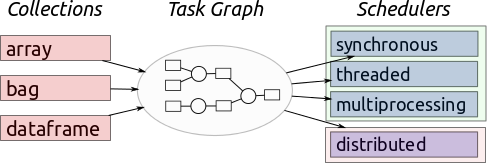

In [26]:
from IPython.display import Image
Image('dask.png')

In [21]:
def procesar_datos_dask(path_archivos: str):
    """Concatenar y limpiar base de datos"""
    # lee archivos
    df = dd.read_csv(path_archivos, dtype={'Bici': str})

    # parse dates
    df = df.assign(
        Fecha_Retiro=df.Fecha_Retiro + ' ' + df.Hora_Retiro,
        Fecha_Arribo=df.Fecha_Arribo + ' ' + df.Hora_Arribo,
    ).drop(['Hora_Retiro', 'Hora_Arribo'], axis=1)
    
    fecha_retiro = df.Fecha_Retiro.map_partitions(pd.to_datetime,
                                                  format='%d/%m/%Y %H:%M:%S',
                                                  meta=('date', 'M8[ns]'))
    fecha_arribo = df.Fecha_Arribo.map_partitions(pd.to_datetime,
                                                  format='%d/%m/%Y %H:%M:%S',
                                                  meta=('date', 'M8[ns]'))
    df = df.assign(
        Fecha_Retiro=fecha_retiro,
        Fecha_Arribo=fecha_arribo,
    )
    delta_sec = (df.Fecha_Arribo - df.Fecha_Retiro).dt.seconds
    duracion_viaje = (delta_sec / 60).round()
    duracion_viaje = duracion_viaje.astype(int)
    df = df.assign(duracion_viaje=duracion_viaje)
    return df

path = 'data/ecobici/*.csv'

df_test = procesar_datos_dask(path)

In [23]:
df_test

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,duracion_viaje
npartitions=4,,,,,,,,
,object,int64,object,int64,datetime64[ns],int64,datetime64[ns],int64
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [22]:
df_test.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,duracion_viaje
0,M,22,9280,144,2017-05-01 00:00:15,448,2017-05-01 00:09:13,9
1,M,31,4389,10,2017-05-01 00:00:23,131,2017-05-01 00:21:52,21
2,F,49,1754,86,2017-05-01 00:01:22,1,2017-05-01 00:10:20,9
3,M,23,2333,316,2017-05-01 00:03:06,304,2017-05-01 00:06:22,3
4,M,30,6990,385,2017-05-01 00:03:29,135,2017-05-01 00:35:03,32


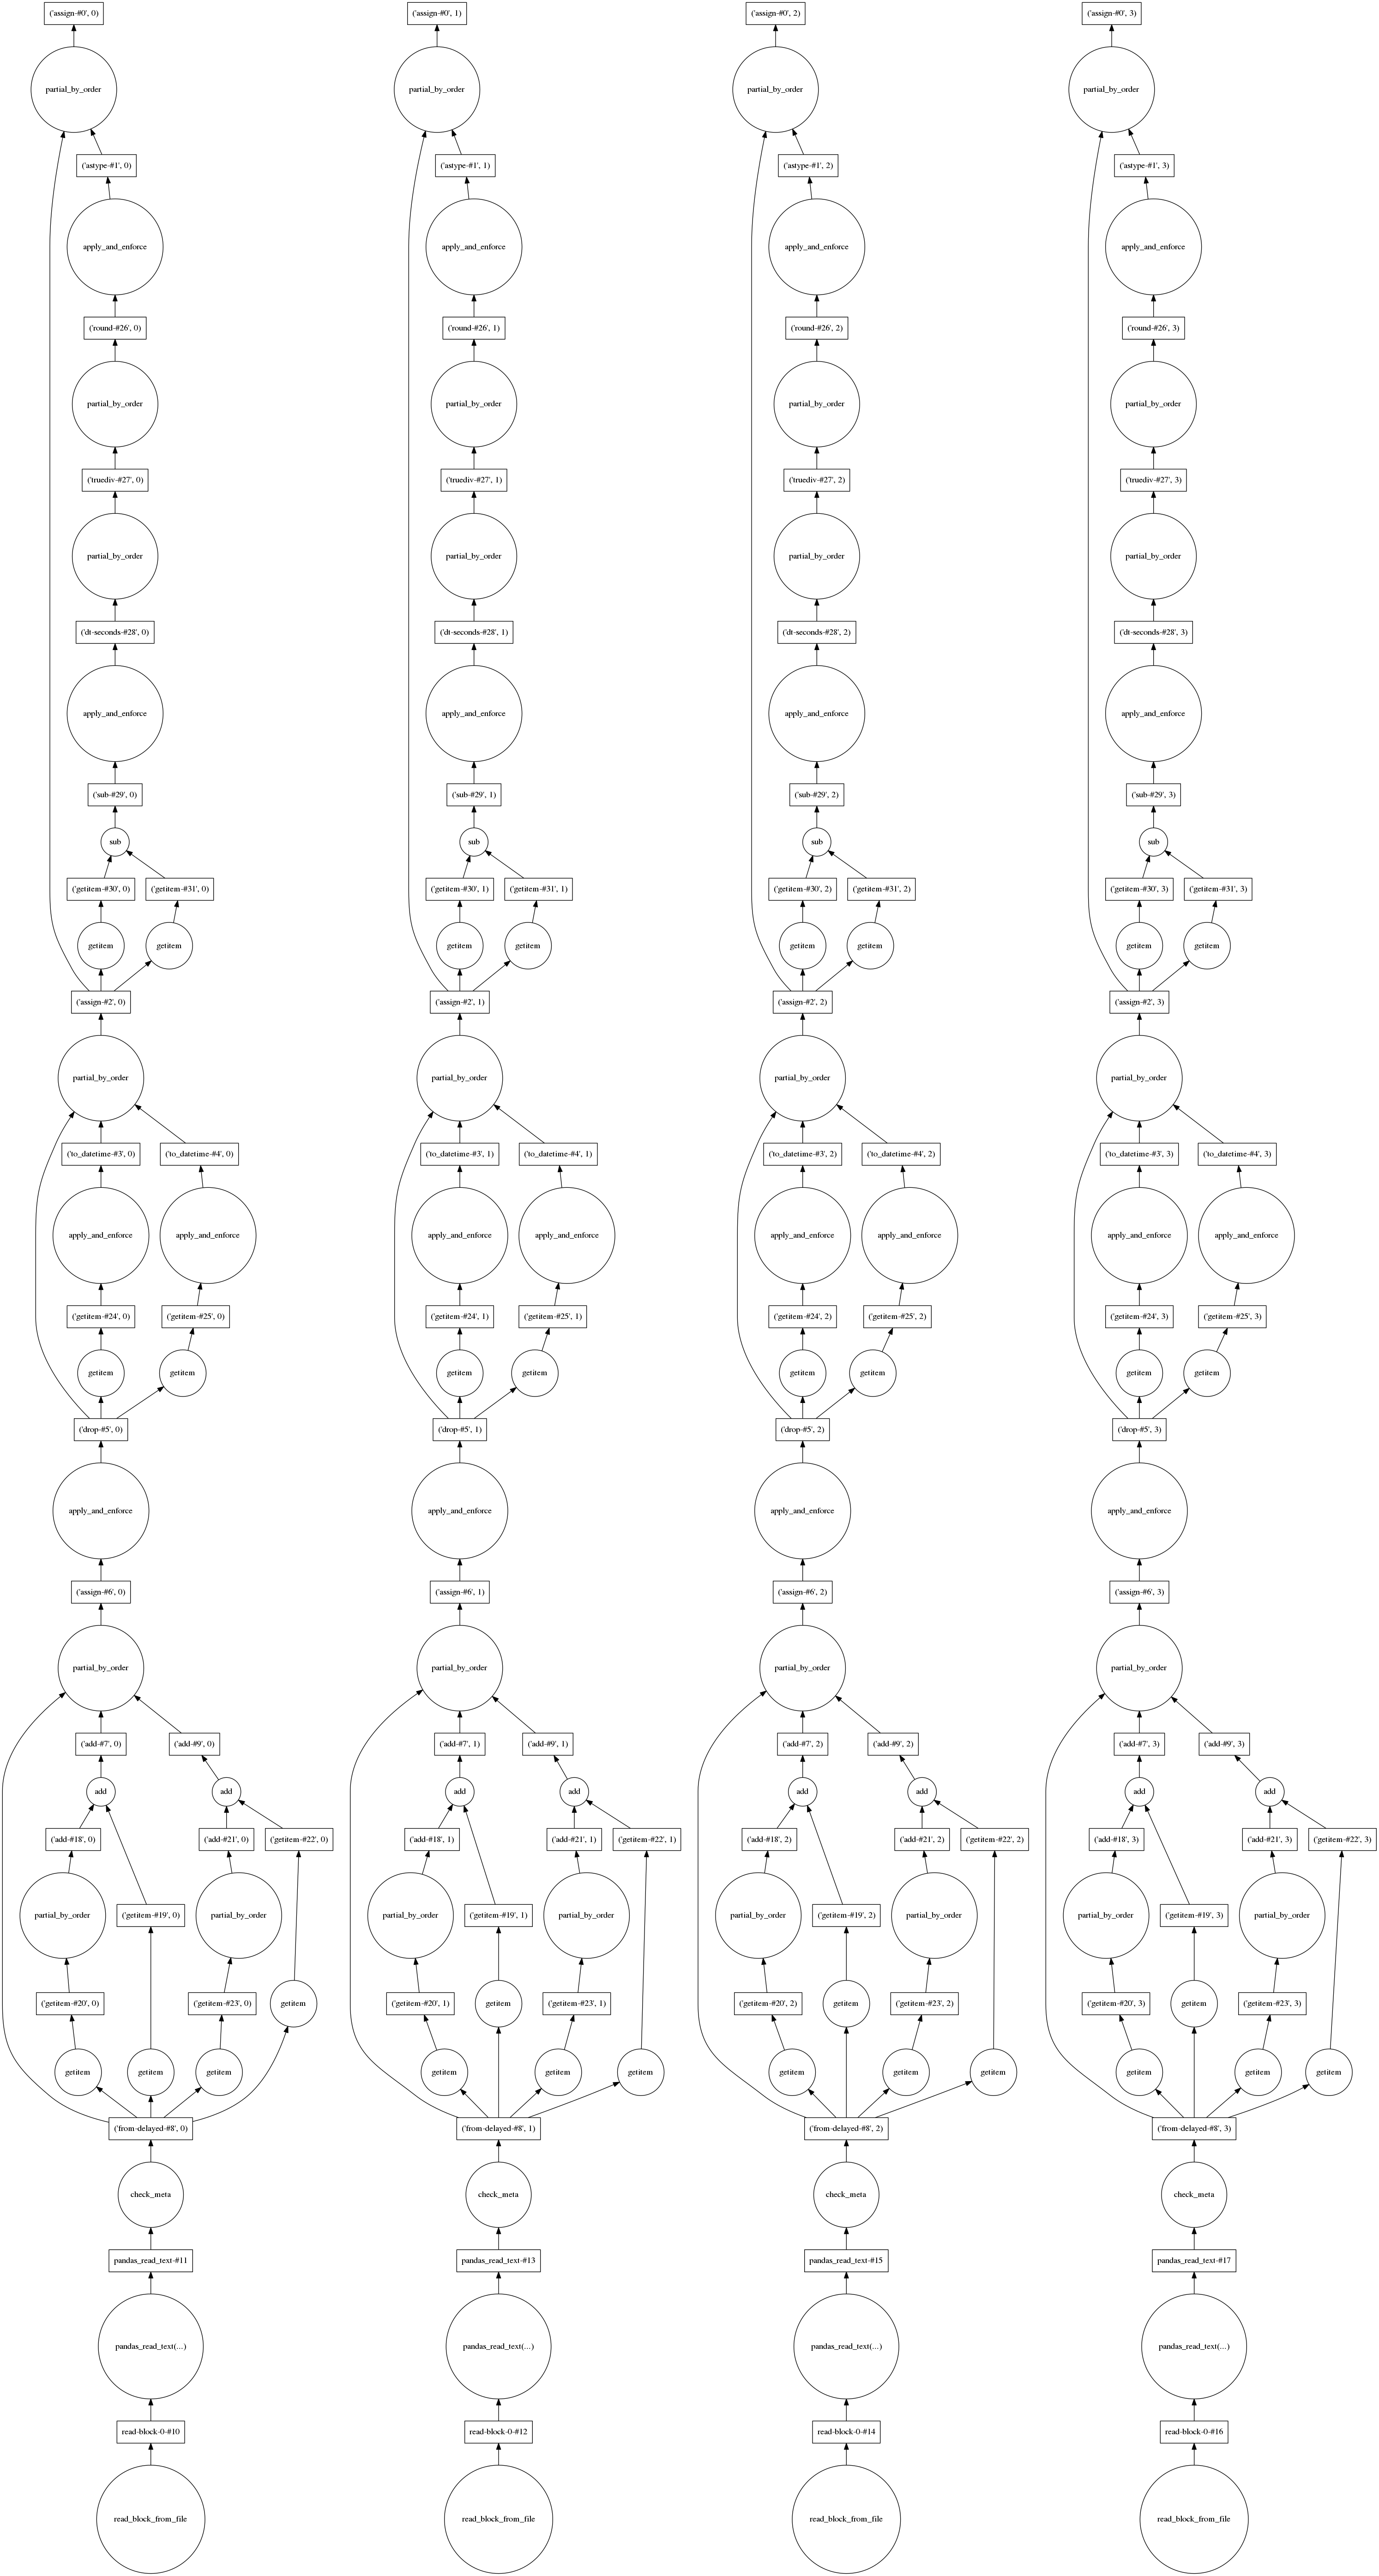

In [24]:
df_test.visualize()

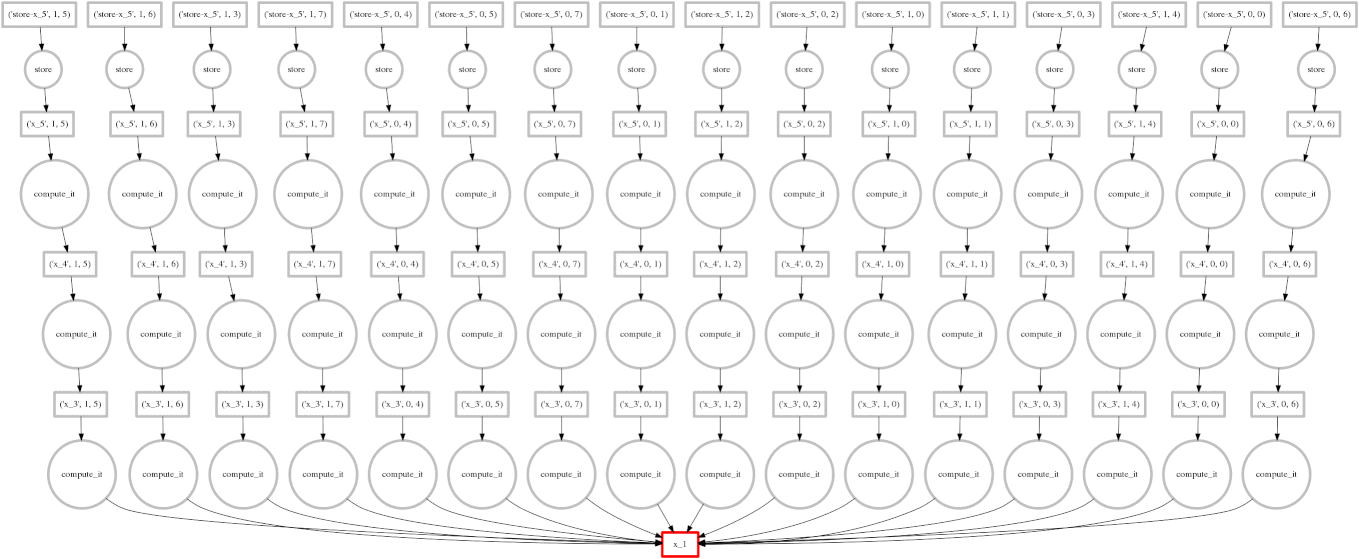

In [27]:
Image('async-embarrassing.gif')

In [28]:
df_test = df_test.compute()

In [30]:
df_test.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,duracion_viaje
0,M,22,9280,144,2017-05-01 00:00:15,448,2017-05-01 00:09:13,9
1,M,31,4389,10,2017-05-01 00:00:23,131,2017-05-01 00:21:52,21
2,F,49,1754,86,2017-05-01 00:01:22,1,2017-05-01 00:10:20,9
3,M,23,2333,316,2017-05-01 00:03:06,304,2017-05-01 00:06:22,3
4,M,30,6990,385,2017-05-01 00:03:29,135,2017-05-01 00:35:03,32
